<a href="https://colab.research.google.com/github/dusdnKR/SWCON425/blob/main/lec28_notebook_for_students/swcon425_lec28_notebook_for_students.ipynb?hl=ko" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 밑바닥부터 GPT 모델 구현하기

In [1]:
# pip install numpy==1.24.1

In [2]:
from importlib.metadata import version

print("맷플롯립 버전:", version("matplotlib"))
print("파이토치 버전:", version("torch"))
print("tiktoken 버전:", version("tiktoken"))

맷플롯립 버전: 3.10.8
파이토치 버전: 2.0.1+cu118
tiktoken 버전: 0.12.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="800px">

## 4.1 구조 구현하기

지난 수업 시간에 설명한 GPT와 Llama 모델은 원본 트랜스포머 구조의 디코더 부분을 기반으로 순차적으로 단어를 생성합니다.  
이런 LLM을 <b>디코더 기반 LLM</b>이라 부릅니다.

전통적인 딥러닝 모델과 비교하면 LLM은 규모가 큰 편이기는 합니다.  
이는 코드의 양이 아니라 파라미터 개수가 방대하다는 의미로, 실제 구현은 어렵지 않습니다.

LLM은 많은 구성 요소의 반복으로 이루어져 있습니다.  
각각의 구성 요소를 구현한 뒤, 이를 결합하여 최종 GPT 모델을 만들어보겠습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="600px">

이전 실습에서는 이해를 돕기 위해 토큰 입력과 출력의 임베딩 차원을 작게 했습니다.  
이제는 GPT-2 모델와 같은 임베딩 크기를 사용하여 진행하겠습니다.

Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)에 나온 가장 작은 GPT-2 모델 구조(1억 2,400만 파라미터, 124M)를 구현하겠습니다(처음에는 1억 1,700만 파라미터라고 보고되었지만 나중에 모델 저장소에 수정된 값으로 공개되었습니다).

여기서 구현한 모델은 345M 파라미터, 762M 파라미터, 1.5B 파라미터를 가진 모델과도 호환 가능합니다.  
구조는 동일하기 때문에 설정 값만 바꾸면 다룰 수 있는 파라미터의 개수가 늘어나기 때문입니다.

124M 파라미터의 GPT-2 모델 설정은 다음과 같습니다.

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘사전 크기
    "context_length": 1024, # 문맥 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 개수
    "n_layers": 12,         # 층 개수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리, 키, 값을 만들 때 편향 포함 여부
}

- `"vocab_size"`는 BPE 토크나이저에서 사용하는 어휘 사전의 토큰 개수(50,257 토큰)를 나타냅니다.
- `"context_length"`는 위치 임베딩으로 모델이 다룰 수 있는 입력 토큰의 최대 개수와 같습니다.
- `"emb_dim"`은 임베딩 크기를 나타내며, 각 토큰을 768 차원의 벡터로 변환합니다.
- `"n_heads"`는 멀티 헤드 어텐션 메커니즘에 있는 어텐션 헤드의 개수입니다.
- `"n_layers"`에는 모델에 있는 트랜스포머 블록의 개수를 지정합니다. (추후 설명하겠습니다)
- `"drop_rate"`는 과대적합을 막기 위한 드롭아웃 메커니즘의 강도를 지정합니다.
- `"qkv_bias"`는 멀티 헤드 어텐션의 Linear 층에서 쿼리, 키, 값을 계산할 때 편향 유닛을 도입할지 여부를 결정합니다. 본 실습에서는 고려하지 않아도 괜찮습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="800px">

GPT 모델은 여러 구성 요소가 반복되어 만들어진다고 설명했습니다.  
우선, 최종 모델의 껍데기인 GPT backbone을 구현하고, GPT 모델 구성에 필요한 하위 구성 요소를 만들겠습니다.

In [4]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="650px">

방금 만든 GPT backbone이 잘 작동하는지 확인해보겠습니다.

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("출력 크기:", logits.shape)
print(logits)

출력 크기: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 층 정규화로 활성화 정규화하기

층 정규화(Layer Normalization, [Ba et al. 2016](https://arxiv.org/abs/1607.06450))는 신경망 층의 활성화를 평균이 0이고 분산이 1이 되도록 조정합니다.  
이를 통해 훈련을 안정화하고 가중치 수렴 속도를 높일 수 있습니다.

LayerNorm은 트랜스포머 블록의 멀티 헤드 어텐션 모듈 전후에 적용됩니다. 또한 최종 출력 층 전에도 적용됩니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="600px">

작은 입력 샘플을 간단한 신경망 층에 통과시켜 LayerNorm의 작동 방식을 알아 보겠습니다.  
랜덤한 값을 가지는 5차원짜리 샘플 2개를 만들겠습니다.

In [ ]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)

layer = ### your code
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


두 개의 입력에 대해 각각 평균과 분산을 계산해 보겠습니다.

In [ ]:
mean = ### your code
var = ### your code

print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
분산:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


정규화는 두 입력(행)에 대해 독립적으로 적용되어야 합니다.  
`mean()`과 `var()` 함수에 dim=-1을 적용하면 마지막 차원을 따라 계산이 수행됩니다.

지금은 2차원 행렬에 대해 수행하고 있기 때문에 dim=-1은 dim=1을 의미합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="600px">

평균을 빼고, 분산의 제곱근(표준편차)으로 나누어 평균이 0이고 분산이 1이 되도록 만듭니다.

In [ ]:
out_norm = ### your code
print("정규화된 층 출력:\n", out_norm)

norm_mean = out_norm.mean(dim=-1, keepdim=True)
norm_var = out_norm.var(dim=-1, keepdim=True)
print("평균:\n", norm_mean)
print("분산:\n", norm_var)

정규화된 층 출력:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
평균:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


각 입력의 평균은 0이고 분산은 1입니다. 물론, 약간의 오차는 존재합니다.  
결과를 보기 쉽도록 파이토치의 `sci_mode`를 끌 수 있습니다.

In [10]:
torch.set_printoptions(sci_mode=False)
print("평균:\n", norm_mean)
print("분산:\n", norm_var)

평균:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


이제, 동일한 역할을 수행하는 `LayerNorm` 클래스를 구현하여, 반복적으로 사용하기 편하게 만들겠습니다.

이때, 추가적으로 두 개의 훈련 가능한 파라미터 `scale`과 `shift`를 추가하겠습니다.  
초기 `scale`(=1)과 `shift`(=0)은 아무런 영향을 미치지 못하지만, 만약 훈련 과정에서 두 파라미터를 조정하는 것이 훈련 작업에서 모델의 성능을 향상시킨다고 판단하는 경우 자동으로 값이 변화하게 됩니다.
이러한 유연성을 통해 모델은 처리하는 데이터에 가잘 잘 맞는 스케일 조정과 이동을 학습할 수 있습니다.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = ### your code
        self.shift = ### your code

    def forward(self, x):
        mean = ### your code
        var = ### your code
        norm_x = ### your code
        return ### your code

`eps`(epsilon, $\epsilon$)는 분산이 0일 경우 0으로 나누어지는 것을 방지해줍니다.

`unbiased=False`는 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 식으로 분산을 계산한다는 의미입니다.  
`n`은 샘플 크기로, `True`로 설정할 경우 분모가 `n-1`인 베셀 보정(Bessel's correction)이 적용됩니다.  
LLM에서 임베딩 차원 `n`은 매우 크므로 `n`과 `n-1`을 사용하는 차이는 무시할 수 있습니다.  
또한, GPT-2가 `unbiased=False` 설정으로 학습되었으므로, 호환성을 위해 동일한 설정을 적용하였습니다.

이제 `LayerNorm`을 실제로 테스트해 보겠습니다.

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [13]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="700px">

## 4.3 GELU 활성화 함수를 사용하는 피드 포워드 네트워크 구현하기

활성화 함수는 인공 신경망에서 각 뉴런(노드)의 입력 신호를 받아 출력 신호를 결정하는 함수입니다.  
딥러닝에서는 활성화 함수로 주로 간단하면서 다양한 신경망 구조에 효과적인 ReLU(Rectified Linear Unit)를 사용합니다.

LLM에서는 전통적인 ReLU 외에 주로 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)를 사용합니다.  
GELU와 SwiGLU는 각각 가우스 오차 함수와 시그모이드 GLU를 사용한 더 복잡하고 부드러운 활성화 함수입니다.  

이번 실습에서는 GELU 활성화 함수([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))를 이용해보겠습니다.

GELU의 정확한 정의는 GELU(x) = x⋅𝛷(x)입니다. 여기서 𝛷(x)는 표준 가우스 누적 분포 함수(가우스 오차 함수)입니다.  
GPT-2에서는 쉬운 계산을 위해 근사식 $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$을 사용하였습니다.

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return ### your code

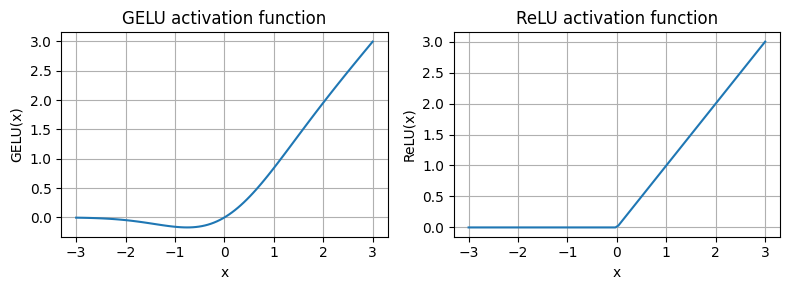

In [ ]:
import matplotlib.pyplot as plt

gelu, relu = ### your code

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

ReLU는 양수는 그대로, 음수는 무조건 0으로 출력하는 구간별 선형 함수(piecewise linear function)입니다.  
GELU는 부드러운 비선형 함수로, ReLU와 비슷하지만 모든 음수 값의 그레이디언트를 0으로 만들지 않습니다.  
(대략 x = -0.75에서는 그레이디언트가 0이 됩니다)

간단한 ReLU와 달리, 이러한 GELU의 비선형 구조는 딥러닝 모델의 성능을 향상시킵니다.

이번에는 LLM의 트랜스포머 블록에 사용할 작은 신경망 모듈인 `FeedForward`를 구현해보겠습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="600px">

FeedForward 층은 입력층 → 은닉층 → 출력층을 거치며 모델이 더욱 복잡하고 추상적인 패턴을 학습할 수 있게 합니다.  
임베딩 차원을 4배로 늘려서 GELU를 적용한 뒤, 다시 원래 임베딩 크기로 돌리는 작업을 수행하도록 설계하겠습니다.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            ### your code
            ### your code
            ### your code
        )

    def forward(self, x):
        return self.layers(x)

124M짜리 모델의 임베딩 벡터 크기는 다음과 같이 설정되어 있습니다.

In [17]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="600px">

이 임베딩 벡터를 FeedForward 층에 넣었을 때 내부적으로 이루어지는 연산은 위와 같습니다.

In [ ]:
# 입력 크기: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)

ffn = ### your code
out = ### your code
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: torch.Size([2, 3, 768])
out.shape: torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="600px">

## 4.4 숏컷 연결 추가하기

숏컷 연결(shortcut connection)은 스킵 연결(skip connection)이나 잔차 연결(residual connection)이라고도 불립니다.  
숏컷 연결은 컴퓨터 비전 분야의 심층 신경망에서의 그래디언트 소실 문제를 완화하기 위해 만들어진 아이디어입니다.

<img src="./image/lec28_01.png" width="1000px">

그래디언트 소실(Vanishing Gradient) 문제는 역전파(Backpropagation) 과정에서 기울기(Gradient) 값이 계속 작아져 0에 가까워지면서, 앞쪽 레이어(층)의 가중치가 제대로 업데이트되지 않아 학습이 멈추는 현상을 말합니다.  

<img src="./image/lec28_00.png" width="1000px">

숏컷이라는 이름에서 짐작할 수 있듯, 이 connection은 층과 층 사이를 연결하는 지름길과 같습니다.  
이 연결을 통해 층을 거치지 않은 그래디언트와 층을 거친 후의 그래디언트를 더해, 원래의 값이 아주 작아지는 걸 방지합니다.

구현 자체는 어렵지 않습니다. 이전의 출력 값을 저장해 두었다가, layer를 거친 이후 더해주기만 하면 됩니다.

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = ### your code
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name}의 평균 그래디언트: {param.grad.abs().mean().item()}")

숏컷 연결의 구현이 끝났습니다.  
이제 숏컷 연결 유무에 따른 그래디언트 값을 확인해보겠습니다.

우선, 숏컷 연결이 없을 때의 그래디언트 값을 출력해 보겠습니다.

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ### your code
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight의 평균 그래디언트: 0.00020173590746708214
layers.1.0.weight의 평균 그래디언트: 0.0001201116101583466
layers.2.0.weight의 평균 그래디언트: 0.0007152042235247791
layers.3.0.weight의 평균 그래디언트: 0.0013988739810883999
layers.4.0.weight의 평균 그래디언트: 0.00504964729771018


역전파를 거치며 앞쪽 layer로 올수록 평균 그래디언트 값이 작아지는 것을 확인할 수 있습니다.

다음으로, 숏컷 연결이 있을 때의 그래디언트 값을 출력해 보겠습니다.

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ### your code
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight의 평균 그래디언트: 0.22169791162014008
layers.1.0.weight의 평균 그래디언트: 0.20694102346897125
layers.2.0.weight의 평균 그래디언트: 0.32896995544433594
layers.3.0.weight의 평균 그래디언트: 0.2665732204914093
layers.4.0.weight의 평균 그래디언트: 1.3258541822433472


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="1000px">

출력에서 확인할 수 있듯이, 평균 그래디언트 값이 어느정도 보존되는 것을 확인할 수 있습니다.  
숏컷 연결은 이러한 작동 방식으로 앞쪽 층(`layer.0` 층)의 그래디언트 소실 문제를 막습니다.

## 4.5 어텐션과 선형 층을 트랜스포머 블록에 연결하기

이제, 지금까지 구현한 하위 구성 요소를 모두 결합하여 트랜스포머 블록을 만들어 보겠습니다.  
트랜스포머 블록은 이전 실습의 <b>멀티 헤드 어텐션 모듈</b>에 방금 구현한 <b>피드 포워드 신경망</b>과 <b>숏컷 연결</b>을 결합하여 구현합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="600px">

... → `LayerNorm(1)` → `Masked Multi-head Attention` → `Dropout` + `Shortcut Connection` → `LayerNorm(2)` → `FeedForward`(=`Linear`→`GELU`→`Linear`) → `Dropout` + `Shortcut Connection` → ...  
이런 구조가 되겠네요.

우선 이전 실습에서 구현했던 코드를 실행시킵니다.


In [22]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

다음으로, 방금까지 실습에서 구현한 `FeedForward`, `LayerNorm`을 합쳐서 트랜스포머 블록을 만들겠습니다.  
순서만 맞춰서 `forward(x)`에 작성해주면 됩니다.

만약 `MultiHeadAttention()`, `FeedForward()`, `LayerNorm()`을 어떻게 구현했었는지 기억이 나지 않을 경우, `ctrl`(`command`)+좌클릭으로 아까 작성한 코드를 확인해볼 수 있습니다.

In [ ]:
FeedForward()
LayerNorm()

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="600px">

... → `LayerNorm(1)` → `Masked Multi-head Attention` → `Dropout` + `Shortcut Connection` → `LayerNorm(2)` → `FeedForward`(=`Linear`→`GELU`→`Linear`) → `Dropout` + `Shortcut Connection` → ...  

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = ### your code
        self.norm1 = ### your code
        self.norm2 = ### your code
        self.dropout = ### your code

    def forward(self, x):
        shortcut = ### your code
        x = ### your code
        x = ### your code
        x = ### your code
        x = ### your code

        shortcut = ### your code
        x = ### your code
        x = ### your code
        x = ### your code
        x = ### your code

        return x

이제 이 트랜스포머 블록을 사용해보겠습니다.

네 개의 토큰으로 구성되고 각 토큰은 768차원의 임베딩 벡터인 입력이 두 개 있다고 가정하겠습니다. (`[2, 4, 768]`)  
트랜스포머 블록은 셀프 어텐션과 피드 포워드 신경망을 적용하여 동일한 크기의 출력을 반환합니다.

In [ ]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # 크기: [batch_size, num_tokens, emb_dim]
block = ### your code
output = ### your code

print("입력 크기:", x.shape)
print("출력 크기:", output.shape)

입력 크기: torch.Size([2, 4, 768])
출력 크기: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="1000px">

이제 GPT 모델의 구조를 재현해보겠습니다.

## 4.6 GPT 모델 만들기

GPT 모델은 트랜스포머 블록을 여러 번 반복하여 사용합니다.  
가장 작은 124M 파라미터의 GPT-2 모델의 경우 12번 반복합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="600px">



`n_layers`는 트랜스포머 블록의 반복 횟수를 정의해주는 설정값입니다.  
이 값을 기준으로 `TransformerBlock`을 반복시키겠습니다.

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = ### your code

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # 크기 [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = ### your code
        x = ### your code
        logits = ### your code
        return logits

이제, 124M 파라미터를 가진 GPT 모델의 설정(`GPT_CONFIG_124M`)을 그대로 적용한 GPT 모델이 완성되었습니다.  
가중치는 랜덤하게 초기화 되었습니다.

In [ ]:
torch.manual_seed(123)
model = ### your code
out = ### your code
print("입력 배치:\n", batch)
print("\n출력 크기:\n", out.shape)
print("\n출력 결과:\n", out)

입력 배치:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

출력 크기:
 torch.Size([2, 4, 50257])

출력 결과:
 tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


이 모델이 실제로 1억 2,400만개의 파라미터를 가지고 있는지 간단하게 계산해보겠습니다.

In [28]:
total_params = sum(p.numel() for p in model.parameters())
print(f"총 파라미터 개수: {total_params:,}")

총 파라미터 개수: 163,009,536


구현한 모델의 파라미터 개수는 1억 2,400만개가 아니라 1억 6,300만개로 확인됩니다.  
이는 실제 구현 단계에서는 동일한 역할을 하는 일부 layer의 가중치를 중복하여 사용하기 때문입니다.

토큰 임베딩 층은 50,257차원의 One-Hot Encoding된 입력 토큰을 768차원의 임베딩 표현에 투영합니다.  
출력 층은 768차원의 임베딩을 단어로 변환하기 위해 50,257차원의 표현으로 투영합니다.

따라서 임베딩 층과 출력 층의 파라미터 개수는 동일하며, 이 둘은 동일하게 사용될 수 있습니다.

In [29]:
print("토큰 임베딩 층의 가중치 크기:", model.tok_emb.weight.shape)
print("출력 층의 가중치 크기:", model.out_head.weight.shape)

토큰 임베딩 층의 가중치 크기: torch.Size([50257, 768])
출력 층의 가중치 크기: torch.Size([50257, 768])


GPT-2 논문에서 연구자들은 가중치 묶기(weight tying)를 적용하여 토큰 임베딩 층(`tok_emb`)의 가중치를 출력 층에 재사용했습니다. (`self.out_head.weight = self.tok_emb.weight`)  
결과적으로 출력 층의 파라미터 개수를 빼면 1억 2,400만 파라미터의 모델이 됩니다.

In [30]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"가중치 묶기를 고려한 훈련 가능한 파라미터 개수: {total_params_gpt2:,}")

가중치 묶기를 고려한 훈련 가능한 파라미터 개수: 124,412,160


마지막으로 모델에 필요한 메모리 크기를 계산해 보겠습니다.

In [31]:
# 총 크기를 바이트 단위로 계산합니다(float32라 가정하면 파라미터당 4바이트입니다).
total_size_bytes = total_params * 4

# 메가바이트로 변환합니다.
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"모델에 필요한 메모리 공간: {total_size_mb:.2f} MB")

모델에 필요한 메모리 공간: 621.83 MB


## 4.7 텍스트 생성하기

앞에서 구현한 GPT와 같은 LLM은 한 번에 하나의 단어를 생성합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="500px">

이제, 모델이 텍스트를 생성할 수 있도록 만들어 보겠습니다.

간단하고 빠르게 텍스트를 생성하는 그리디 디코딩(greedy decoding)을 구현해보겠습니다.  
그리디 디코딩에서는 각 단계마다 모델이 가장 높은 확률을 가진 단어(또는 토큰)을 다음 출력으로 선택합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="900px">

모델 출력의 가장 마지막 벡터가 마지막 토큰의 출력을 나타내므로 마지막 벡터의 결과만을 사용합니다.  
마지막 벡터는 단어사전의 각 토큰에 대한 logit을 나타냅니다.  
이를 softmax를 이용해 확률 분포로 변환하고, 가장 높은 확률을 가진 인덱스(=토큰 ID)를 알아냅니다.  
해당 인덱스 번호를 단어 사전의 토큰 ID와 대조하면(decoding) 다음 단어를 알아낼 수 있습니다.

위 과정을 통해 알 수 있겠지만, 모델의 출력 자체가 각 토큰의 logit이기 때문에 softmax 없이 argmax를 적용해도 결과는 같습니다.

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):

        # 현재 문맥이 모델이 지원하는 문맥 크기를 초과하면 잘라냅니다.
        # 예를 들어, LLM이 5개 토큰만 지원하고 문맥 크기가 10이라면, 마지막 5개 토큰만 문맥으로 사용합니다.
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = ### your code

        # 마지막 타임 스텝만 사용하므로 (batch, n_token, vocab_size)가 (batch, vocab_size)가 됩니다.
        logits = ### your code

        # 확률을 얻기 위해 소프트맥스를 적용합니다.
        probas = ### your code

        # 가장 높은 확률 값을 가진 항목의 인덱스를 얻습니다. (batch, 1)
        idx_next = ### your code

        # 선택한 인덱스를 현재 시퀀스에 추가합니다. (batch, n_tokens+1)
        idx = ### your code

    return idx

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="700px">

이렇게 알아낸 다음 단어의 토큰 ID를 기존 시퀀스에 붙이고, 다시 다음 단어를 예측하기를 반복하면 최종 문장이 완성됩니다.

실제로 테스트해보도록 하겠습니다.  
임의의 임력 샘플을 준비해줍니다.

In [33]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("인코딩된 ID:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

인코딩된 ID: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


현재 학습이 아닌 추론 과정에 있기 때문에 모델을 추론 모드로 설정(`model.eval()`)해주어야 합니다.  
그럼 dropout이 적용되지 않습니다.

방금 만든 `generate_text_simple()`을 사용해보겠습니다.

`generate_text_simple(model, idx, max_new_tokens, context_size)`

In [ ]:
### your code

out = ### your code

print("출력:", out)
print("출력 길이:", len(out[0]))

출력: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
출력 길이: 10


과거, 배치 차원을 고려하여 입력이 배치 단위로 처리되도록 만들었습니다.  
현재 테스트에서는 배치가 1인 입력과 같은 상태입니다.

배치 차원을 삭제하고 결과 토큰 ID를 다시 텍스트로 디코딩해보겠습니다.

In [35]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


도저히 이해할 수 없는 문장이 출력되었습니다.  
이는 아직 모델을 훈련하지 않은 상태이기 때문입니다.  

방금 만든 모델을 훈련하는 과정은 과제로 나갈 예정입니다.

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
본 강의자료는 세바스찬 라시카(Sebastian Raschka)의 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> (<a href="<a href="http://tensorflow.blog/llm-from-scratch">밑바닥부터 만들면서 배우는 LLM</a>)의 예제를 참고하여 제작되었습니다.
</font>
</td>
</tr>
</table>